First part is to import an image into our google doc. Just place the path to the file in cv2.imread()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from numpy import ndarray
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import cv2 as cv2
from google.colab.patches import cv2_imshow

In [ ]:
#this section is optional. If you dont want to find an image, you can use phots of myself as a proof of concept.

!git clone https://github.com/davidmaunder47/SkinDetectionImages.git

fatal: destination path 'SkinDetectionImages' already exists and is not an empty directory.


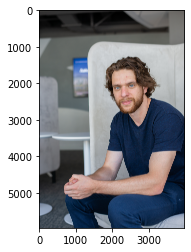

In [76]:
#insert Imagepathway into the photo variable below
#or use a photo from the repository downloaded in the above cell
photo= "/content/SkinDetectionImages/SkinDetectionImages/Maunder, John David_JPP0785.jpg"
image = cv2.imread(photo)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()

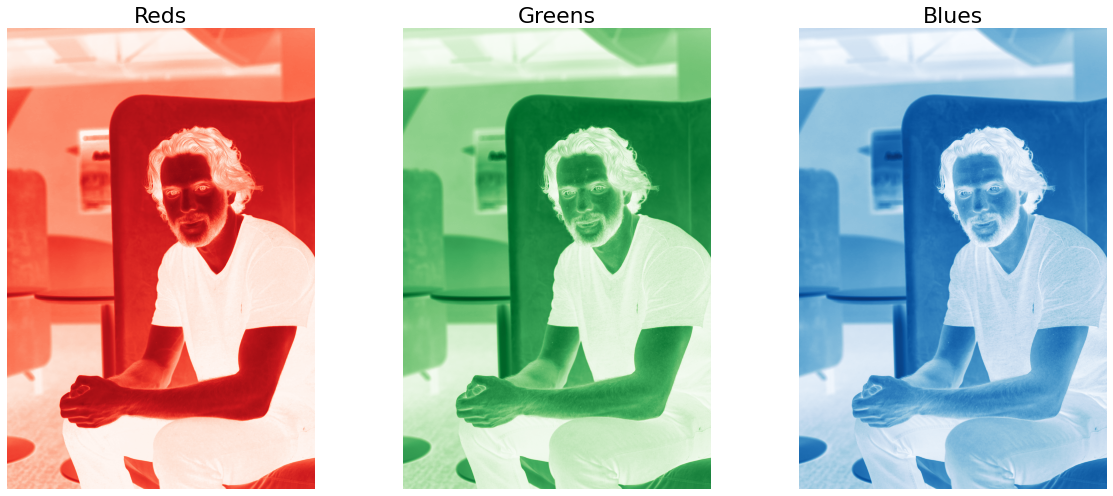

In [77]:
"""
The below code will print out three versions of the imported photo above. The versions will be the Red, Green, and Blue verisons of our photo.
The point of this code is to see the colour breakdown of the imported photo.
"""

def rgb_splitter(image):
    rgb_list = ['Reds','Greens','Blues']
    fig, ax = plt.subplots(1, 3, figsize=(17,7), sharey = True)
    for i in range(3):
        ax[i].imshow(image[:,:,i], cmap = rgb_list[i])
        ax[i].set_title(rgb_list[i], fontsize = 22)
        ax[i].axis('off')
    fig.tight_layout()
rgb_splitter(image_rgb)

The next step is to find an appropriate range of pixels for our skin tone.

[]

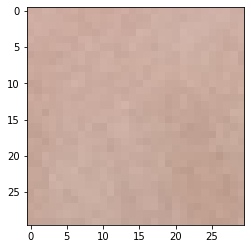

In [81]:
"""
This part requires a little bit of manual work. 
The below four numbers are coordinates of a box. The box will represent the colour of pixels we are trying to find. 
The skin detection algorithm needs to know which skin colour it is looking for before it isolates skin parts in a photo. Therefore, we have to provide a 
pixel location as an startingpoint for the algoirthm to run. 

We can see where we have taken the pixels from, in the code block below. The area we have selected will appear in a red box. I would recommend starting 
with a bigger box and then filtering to a 20 by 20 box for the best results. 
"""
r1 = 4900
r2 = 4930
c1 = 2100
c2 = 2130
fig, ax = plt.subplots()
patch_plot = image_rgb[r1:r2,c1:c2]

ax.imshow(patch_plot);
ax.plot()



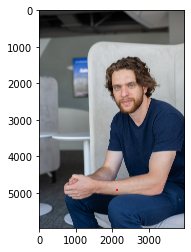

In [82]:
"""
Red box will display where we have selected our pixel box from the above code cell. 
(rows, Columns) (0,0) is the top left of the image. Bottom right would be (Width of image, Hieght of Image)
"""

#to move box right increase c1
#to go down increase r1
rect = Rectangle((c1, r1), (c2-c1), (r2-r1), linewidth=1, edgecolor='red', facecolor='none')
# Add the patch to the Axes
plt.imshow(image_rgb)

plt.gca().add_patch(rect)


The below is just a variable to be used for our functions later 

In [83]:
patch = [r1,r2,c1,c2]

The below function will take in our original image and produce three different masks. A red mask, a blue, mask and a combination of the two. The ending mask will be the combination of our green and blue mask. 
The function will work as follows:
1. Take the guassian average of the patch given by the user
2. convert the original image to the ratio of red/green components of the image
3.compare the patch_ratio_average to each pixel from step 2. Compare means see if the patch_raito_average is close (15% greater or less than) to the red/green average from the original image. If it is make it white if not make it black.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


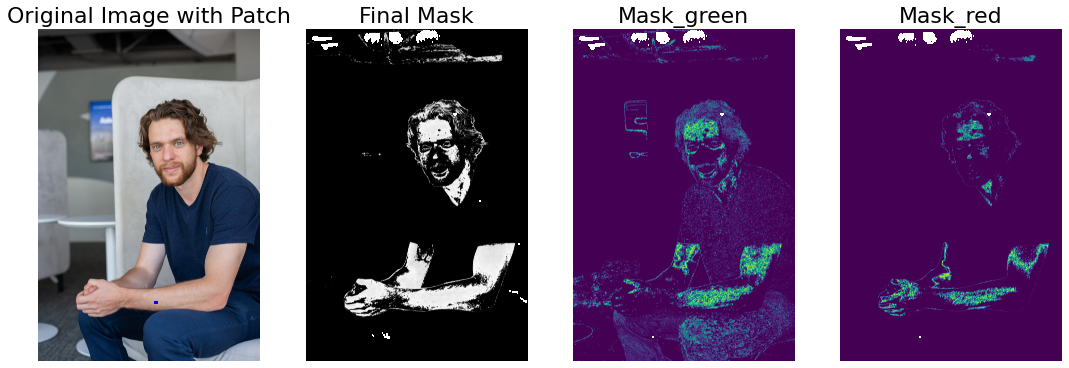

In [84]:
#basic function to get the guassian number per patch pixel. 
def gaussian(p,mean,std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

#Our main algorith,
def mask_algo(image, patch_coor, mean = 1, std = 1):
    patch = image[patch_coor[0]:patch_coor[1],
                  patch_coor[2]:patch_coor[3]]
    #convert the original image to its red and green components per each pixel
    image_r = image[:,:,0] /image.sum(axis=2)
    image_g = image[:,:,1] /image.sum(axis=2)

  
    
    #convert the original image to its red and green components per each pixel
    patch_r = patch[:,:,0] / patch.sum(axis=2)
    patch_g = patch[:,:,1] / patch.sum(axis=2)

    #Calculate the standard deviation and the mean for the patches    
    std_patch_r = np.std(patch_r.flatten())
    mean_patch_r = np.mean(patch_r.flatten())

    std_patch_g = np.std(patch_g.flatten())
    mean_patch_g = np.mean(patch_g.flatten())

    #this is used for our input to display the red and green masks 
    #this is to see the different red and green components
    masked_image_r = gaussian(image_r, mean_patch_r, std_patch_r)
    masked_image_g = gaussian(image_g, mean_patch_g, std_patch_g)

    #now calculate the guassian numbers from the formulas above
    guass_patch_r = gaussian(patch_r, mean_patch_r, std_patch_r)
    guass_patch_g = gaussian(patch_g, mean_patch_g, std_patch_g)

    #take the red/green image for each patch pixel
    patch_ratio = (patch_r/patch_g)   
    #take the average of the patch since we just want one number for our threshold
    #our threshold ratio 
    final_patch_ratio = (patch_ratio.sum()/(patch_ratio.size))
  

    #this will convert the original image into its red and green components
    #we will then compare this to our threshold in our for loop below
    final_mask = (image_r/image_g)

    #this will yeild us our black and white output
    x = final_mask.shape[0]
    y = final_mask.shape[1]
    for i in range(x):
      for j in range(y):
        if (final_mask[i][j] > final_patch_ratio*1.08) or (final_mask[i][j] < final_patch_ratio*0.92):
          final_mask[i][j] = 0

    #the rest of the code is used to display the various images created above 

    #Original image 
    fig, ax = plt.subplots(1,4, figsize=(15,7))
    ax[0].imshow(image)
    ax[0].add_patch(Rectangle((patch_coor[2], patch_coor[0]), 
                               patch_coor[1] - patch_coor[0], 
                               patch_coor[3] - patch_coor[2], 
                               linewidth=2,
                               edgecolor='b', facecolor='none'));
    ax[0].set_title('Original Image with Patch', fontsize = 22)
    ax[0].set_axis_off()
    
    #Final Mask image 
    ax[1].imshow(final_mask, cmap= "gray");
    ax[1].set_title('Final Mask', fontsize = 22)
    ax[1].set_axis_off()
    fig.tight_layout()

    #Green Mask image 
    ax[2].imshow(masked_image_g);
    ax[2].set_title('Mask_green', fontsize = 22)
    ax[2].set_axis_off()
    fig.tight_layout()

    #Red Maks image
    ax[3].imshow(masked_image_r);
    ax[3].set_title('Mask_red', fontsize = 22)
    ax[3].set_axis_off()
    fig.tight_layout()
    
    return final_mask

final_mask = mask_algo(image_rgb, patch)





We can also try a different masking approach. 
1. Get the min and max values of the area we are targeting (patch area) for our given skin tone. 
2. Average these two numbers out
3. Apply an upper and lower threshold value.
4. If a pixel is not between this value set it to zero.
5. Apply masking to Final_mask images and print out the new masked image

This method can be used if the masking is picking up to many colours

Now we can test our Chromaticity values on the new images of steve

In [85]:
#Lighter 
x = image_rgb.shape[0]
y = image_rgb.shape[1]
c = image_rgb.shape[2]
image_copy = cv2.imread(photo)
image_copy_light = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for i in range(c):
  for j in range(x):
    for k in range(y):
      if image_rgb[j][k][i] * 1.15 > 255:
        image_copy_light[j][k][i] = 255
      else:
        image_copy_light[j][k][i] = image_rgb[j][k][i]*1.15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


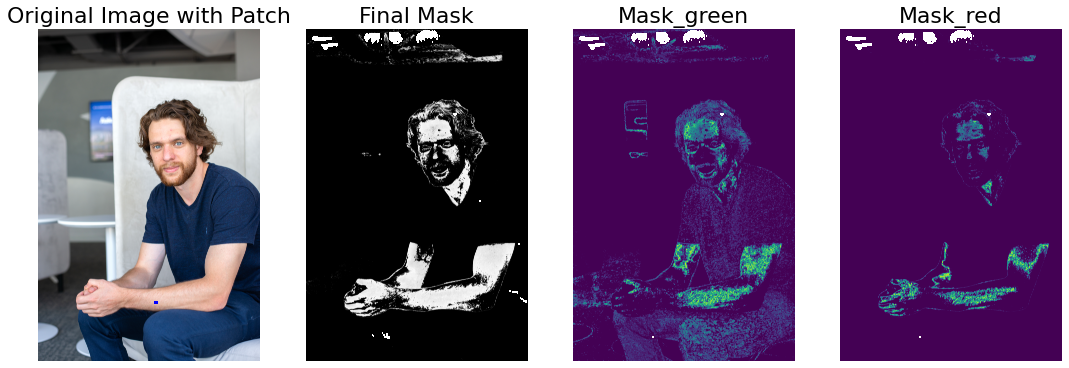

In [86]:
final_mask = mask_algo(image_copy_light, patch)

In [87]:
#Darker
x = image_rgb.shape[0]
y = image_rgb.shape[1]
c = image_rgb.shape[2]
image_copy = cv2.imread(photo)
image_copy_dark = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for i in range(c):
  for j in range(x):
    for k in range(y):
      image_copy_dark[j][k][i] = image_rgb[j][k][i]*0.85

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


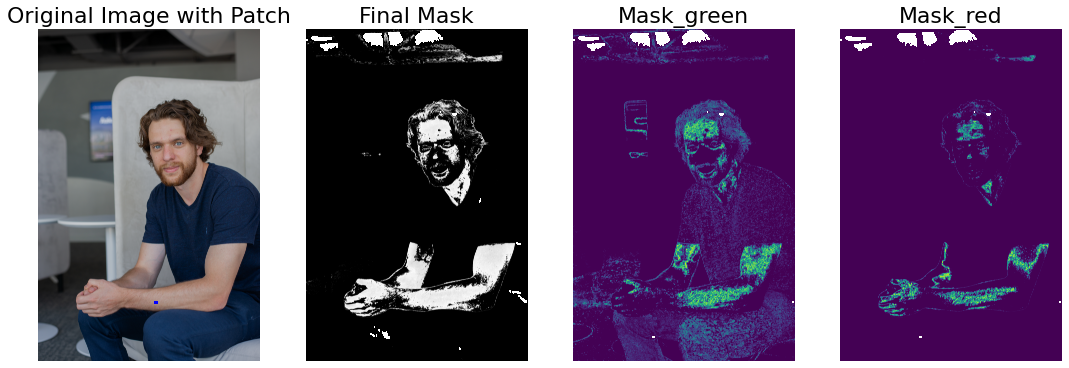

In [88]:
#we are using the same patch as the lighting part 
final_mask = mask_algo(image_copy_dark, patch)

#Analysis on Lightening and Darkening Images

For my specific algoirthm, lightening or darkening an image did not modify the results of my selected images too much. 

This result was in line with my expectations since the lightening algorithm has less effect on photos than a darkening algorithm. The reason for this is our lightening algorithm limits a pixel intensity to 255. This means that any RGB colour pixel that is close to 255 will remain pretty much unchanged. This is in comparison to the darkening algorithm which will change all pixel values by 15%. Since no pixel can be below 0, we did not need to cap any pixels in the darkening algorithm. 

I did not expect to see too much change when darkening or lightening my photos since my algorithm has an upper and lower bound. This means when darkening or lightening the pixels, some pixels below the threshold would be raised to meet it while others would be raised out of the threshold bounds. The darkening algorithm had an opposite effect. For example, when we ran this algorithm, some white pixels were converted to dark pixels and some dark pixels were converted to white pixels. 


#Discussing on ways to improve my algorithm

There are three different approachs that can be used independently or in combination with one another that would improve the results of my skin detection algoirthm. They are (in order of effectiveness):
1. Picking a more representative patch 
2. Widening or limiting the threshold for each image 
3. Changing the mean and standard deviation when calculating the threshold

Each time I ran the algorithm, I would pick a patch location. If the algorithm returned either:
1.	Too many white pixels where no skin could be seen
2.	Too many pixels where no skin is visible 
I would repick the patch until I got something suitable. This improved the algorithm because it automatically gave the algorithm more representative data. This will work for each new image picked, since the user has to pick a patch for the algorithm to run.

Widening or limiting the threshold had varying effects. We could allow the user to set the threshold to be wider or smaller than the set 8% threshold. This would allow the user to keep running the algorithm until they got a more favourable result. I did not include this option in this design as I wanted to see how the threshold would do against out test images. 

When I took the above approach and re-ran my algorithm on each test image using various thresholds, the results varied. Some images that failed to capture skin tone included more skin tone (as white pixels), while at the same time some images started whitening pixels that were not skin pixels. The opposite occurred when we tightened the threshold. 

Changing the mean and standard deviation had similar effects to the widening the threshold. If we increased (decreased) the standard deviation, this would mean we would have a wider range of coloured pixels (or shorter range)that would make it past (fail if we shortened the deviation) our threshold. Therefore, when we increased our standard deviation parameter, and re-ran our tests, our results were similar to widening or shortening the threshold. 



# Ending Conclusions

My biggest takeaway from this assignment is it is very hard to detect skin colour. The reasons I believe is the following:
1.	Having a wide range of skin tones makes it hard to determine the appropriate threshold to use, even when a perfect patch is used as a reference
2.	The lighting in the picture can wrap the skin colour of a person. For example, it can make darker skin appear lighter and lighter skin appear darker
3.	Background images can have similar RGB tones to people’s skin colors
4.	Peoples body hair can distort images
5. Peoples skin tone may vary for each body part. For example if I have a farmers tan, the skin on my stomach will be lighter than the skin on my arm
6. This threshold will not work when mutiple people of different skin tones are placed in one image together

For example, in photo “kang2_rgb”, the tree-stump my friend is sitting on has a similar RGB value (based on the patch I choose) to his skin colour. Because of this, certain parts of the tree were coloured white when they shouldnt have. A similar situation happened in photo “faus2_rgb” and “faus4_rgb” where faus’s skin was similar to objects in the background. Furthermore, in these two images the lighting completely changed his skin colour in certain parts of the image making it hard to perfectly capture which pixels were his skin tone.

Lastly, in image “steve3_rgb”, his body-hair can distort where white pixels should appear. His pale skin contrasts heavily with his dark body hair (chest and beard) making it hard to have a uniform white part where his skin should be. Lastly in "image_rgb" his hat makes certain parts of his face appear darker than it actually is. 
